#**ERROR ANALYSIS**

To reproduce error analysis with other datasets/result files, change the folowing variables in a bellow cell:
```
DATASETS_DIR = "/content/LRC-0C0F/datasets/"
RES_DIR = "/content/LRC-0C0F/results/"
```


In [ ]:
# to download a anonymous github
!git clone https://github.com/fedebotu/clone-anonymous-github
!pip install -r clone-anonymous-github/requirements.txt

# clone our anonymous github
%cd /content/clone-anonymous-github/
from src.download import download_repo 
import os

config = {'url': 'https://anonymous.4open.science/r/LRC-0C0F/',
                    'save_dir': '/content/',
                    'max_conns': 256,
                    'max_retry': 5}
download_repo(config)

%cd /content/

In [45]:
# download our results. Due to limitations of anonymous github, the results are download from google drive (anonymous special account)
!wget --load-cookies /tmp/cookies.txt "https://drive.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1FzIGKGjbrFU_mdaJhEsCkk3FCYeQL6Ju' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1FzIGKGjbrFU_mdaJhEsCkk3FCYeQL6Ju" -O results.zip && rm -rf /tmp/cookies.txt

--2023-01-31 15:46:33--  https://drive.google.com/uc?export=download&confirm=t&id=1FzIGKGjbrFU_mdaJhEsCkk3FCYeQL6Ju
Resolving drive.google.com (drive.google.com)... 173.194.210.139, 173.194.210.102, 173.194.210.100, ...
Connecting to drive.google.com (drive.google.com)|173.194.210.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-ac-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/o5vuk0vj6btgcq68isrq5k57oppg7jdl/1675179975000/13717404105681208342/*/1FzIGKGjbrFU_mdaJhEsCkk3FCYeQL6Ju?e=download&uuid=0ca8ed5e-d455-44ae-a788-e0ae0ce2e957 [following]
--2023-01-31 15:46:33--  https://doc-08-ac-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/o5vuk0vj6btgcq68isrq5k57oppg7jdl/1675179975000/13717404105681208342/*/1FzIGKGjbrFU_mdaJhEsCkk3FCYeQL6Ju?e=download&uuid=0ca8ed5e-d455-44ae-a788-e0ae0ce2e957
Resolving doc-08-ac-docs.googleusercontent.com (doc-08-ac-docs.googleusercontent.com)... 173.194

In [ ]:
!unzip -o results.zip -d LRC-0C0F/

In [47]:
# from google.colab import drive
# drive.mount('/content/drive')

In [48]:
!pip install rpy2==3.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R
install.packages("vcd")
install.packages("dplyr")

In [51]:
%%R
library(stringr)
library(vcd)
library(dplyr)

In [52]:
%%R
MODELS = c("Roberta") # it can also be added: "Bert", "roberta-base", "bert-base"
TEMPLATES = c("T1", "T2", "T3", "TM1", "TM2", "TM3")
DATASETS_DIR = "/content/LRC-0C0F/datasets/"
RES_DIR = "/content/LRC-0C0F/results/"

**Get result filenames according to the selected models and templates**

In [53]:
models2abrev = {'bert-large-uncased-whole-word-masking'.lower():'Bert',
				   'roberta-large'.lower():'Roberta',
                   'roberta-base'.lower(): 'roberta-base',
                   'bert-base-uncased'.lower(): "bert-base"
				  }
templates2abrev = {"' <W1> ' <SEP> ' <W2> '".lower(): 'T1', 
                  " <W1> <SEP> <W2> ".lower(): 'T2',
                  "Today, I finally discovered the relation between <W1> and <W2>.".lower() : 'T3',
                  "Today, I finally discovered the relation between <W1> and <W2>: <W1> is the <LABEL> of <W2>.".lower() : 'T4',
                  "' <W1> ' <MASK> ' <W2> '".lower(): 'TM1', 
                  " <W1> <MASK> <W2> ".lower(): 'TM2',                     
                  "Today, I finally discovered the relation between <W1> and <W2>: <W1> is the <MASK> of <W2>.".lower() : 'TM3',
                 }

In [ ]:
import rpy2
from rpy2 import robjects
import glob
import ast
import re

RES_DIR = robjects.r('RES_DIR')[0]
MODELS = list(robjects.r('MODELS'))
TEMPLATES = list(robjects.r('TEMPLATES'))
list_files_cogalexv = []
for txt_file in glob.glob(RES_DIR + "CogALexV/*.txt"):
    with open(txt_file) as ftxt:
            # line 1: arguments
            par = ast.literal_eval(ftxt.readline())
            if models2abrev[par['model'].lower()] in MODELS and templates2abrev[par['train_templates'][0].lower()] in TEMPLATES:
                list_files_cogalexv.append(re.sub("txt$", "csv",txt_file)) 

list_files_evalution = []
for txt_file in glob.glob(RES_DIR + "EVALution/*.txt"):
    with open(txt_file) as ftxt:
            # line 1: arguments
            par = ast.literal_eval(ftxt.readline())
            if models2abrev[par['model'].lower()] in MODELS and templates2abrev[par['train_templates'][0].lower()] in TEMPLATES:
                list_files_evalution.append(re.sub("txt$", "csv",txt_file))
print(list_files_cogalexv)
print(list_files_evalution)
%Rpush list_files_cogalexv
%Rpush list_files_evalution


In [55]:
%%R
RELATA_COGALEXV = "relata_metadata.txt"
RELATA_EVALUTION = "EVALUTION_RELATA.txt"
PAIRS_METADATA_COGALEXV  = "pairs_metadata.txt"
PAIRS_METADATA_EVALUTION  = "EVALUTION_RELATIONS.txt"

In [56]:
%%R
relata_file_cogalexv = paste(DATASETS_DIR, "CogALexV",RELATA_COGALEXV, sep = "/")
relata_file_evalution = paste(DATASETS_DIR, "EVALution",RELATA_EVALUTION, sep = "/")
pairs_metadata_file_cogalexv = paste(DATASETS_DIR, "CogALexV",PAIRS_METADATA_COGALEXV, sep = "/")
pairs_metadata_file_evalution = paste(DATASETS_DIR, "EVALution",PAIRS_METADATA_EVALUTION, sep = "/")

# read relata files with POS
relata_data_coga = read.table(relata_file_cogalexv, sep = "\t", comment.char = "", quote = "", skip = 1)
relata_data_eval = read.table(relata_file_evalution, sep = "\t", comment.char = "", quote = "")

# read pairs metadata files with agreement
pairs_metadata_coga = read.table(pairs_metadata_file_cogalexv, sep = "\t")
pairs_metadata_eval = read.table(pairs_metadata_file_evalution, sep = "\t")


In [57]:
%%R

readResults = function (list_files)  {
    all_csv = lapply(list_files, function(f) read.csv(f))
    return (all_csv)
}

# read csv files with the results
csv_files_cogalex = readResults(list_files_cogalexv)
csv_files_evalution = readResults(list_files_evalution)

In [58]:
%%R

find_all_well_bad_data = function(csv_files) {
    all_results = sapply(csv_files, function(d) as.logical(d$results))
    total_well_pred = apply(all_results,1, sum)
    all_well_pred = (total_well_pred>=length(csv_files))
    all_bad_pred = (total_well_pred<=0)

    all_well = csv_files[[1]][all_well_pred,]
    all_bad = csv_files[[1]][all_bad_pred,]
    data_all_well_bad = rbind(all_well, all_bad)

    # remove pairs with random relation, if it exits
    data_all_well_bad = data_all_well_bad[tolower(data_all_well_bad$real_rel) != "random",]
    return (data_all_well_bad)
}

data_all_well_bad_coga = find_all_well_bad_data(csv_files_cogalex)
data_all_well_bad_eval = find_all_well_bad_data(csv_files_evalution)

In [59]:
%%R
#all bad in cogalexv
data_all_well_bad_coga[data_all_well_bad_coga$results=="False",c("source", "target", "real_rel", "pred_rel")]

         source        target real_rel pred_rel
53         skin         grape  part_of   random
72       follow          tail      syn   random
140      stable         build    hyper   random
172    division    separation    hyper      syn
230        wave      straight      ant   random
231        wave         curve    hyper   random
232        wave         sound  part_of    hyper
340        sand         beach      syn  part_of
409        crop           cut    hyper   random
459        even          flat      syn   random
598       study        school    hyper  part_of
637         win       victory    hyper      syn
660       sugar         sweet  part_of    hyper
679         eye        needle  part_of   random
720        door       doorway  part_of      syn
736     company      business      syn    hyper
776       stick           log      ant      syn
806        word        speech    hyper  part_of
827        ride          park      ant  part_of
858        soup          meal  part_of  

In [60]:
%%R
#all bad in evalution
data_all_well_bad_eval[data_all_well_bad_eval$results=="False",c("source", "target", "real_rel", "pred_rel")]

            source         target    real_rel    pred_rel
17             law         theory      partof     antonym
18          author         artist     synonym         isa
40      human_body          water hasproperty        hasa
41            door           hole     antonym        hasa
60             man           male         isa hasproperty
62           sport            fun         isa hasproperty
64        aluminum           gray         isa hasproperty
118            sex            fun         isa hasproperty
157         utopia      community      madeof         isa
177          music             tv         isa     antonym
199        volcano         crater      partof        hasa
208            ink          paint     synonym      partof
217          class        teacher     antonym        hasa
235          child            fun        hasa hasproperty
282           curl           wave      partof         isa
301           draw          trace     antonym     synonym
329          p

In [61]:
%%R

addPOSInfo = function (data_all_well_bad, relata_data) {
    pos = gsub(".*-", "", relata_data$V4)
    idxs_1 = sapply(data_all_well_bad$source, function (n) which(n == relata_data$V1))
    data_all_well_bad$POS1 = pos[idxs_1]
    idxs_2 = sapply(data_all_well_bad$target, function (n) which(n == relata_data$V1))
    data_all_well_bad$POS2 = pos[idxs_2]
    data_all_well_bad$equal_POS = data_all_well_bad$POS1==data_all_well_bad$POS2
    return (data_all_well_bad)
}

#add predominant POS information
data_all_well_bad_coga = addPOSInfo(data_all_well_bad_coga, relata_data_coga)
data_all_well_bad_eval = addPOSInfo(data_all_well_bad_eval, relata_data_eval)

# remove pairs with unknown POS for one of the words in the pair
data_all_well_bad_pos_coga = data_all_well_bad_coga[data_all_well_bad_coga$POS1 != "NULL",]
data_all_well_bad_pos_coga = data_all_well_bad_pos_coga[data_all_well_bad_pos_coga$POS2 != "NULL",]

data_all_well_bad_pos_eval = data_all_well_bad_eval[data_all_well_bad_eval$POS1 != "NULL",]
data_all_well_bad_pos_eval = data_all_well_bad_pos_eval[data_all_well_bad_pos_eval$POS2 != "NULL",]

In [62]:
%%R
# add inferred POS for pairs
# inferred pos for a pair: 
# - if source and target words have equal predominant POS, 
#   the inferred POS = the predominant POS
# - if the predomimant POSs are different:
#   - if there is only one POS in the intersection of the distribution of POS 
#     of the source and target words, the inferred POS = the intersection POS
#   - otherwise, the inferred POS = UNCLEAR  
addInferredPOS = function(data_all_well_bad_pos, relata_data) {
   # 1. Create list of POS distribution for words
    list_POS_dis = str_split(relata_data$V5, "/")
    list_POS_dis_label = lapply(list_POS_dis, function(s) gsub("_[0-9]+", "", s))
    names(list_POS_dis_label) = relata_data$V1 

    inferredPOS = function(row_csv) {
        if (row_csv['equal_POS']) {
            return (row_csv['POS1'])
        } else {
            dist_source = list_POS_dis_label[[row_csv['source']]]
            dist_target = list_POS_dis_label[[row_csv['target']]]
            if (sum(dist_source %in% dist_target) == 1) {
                return (tolower(substr(dist_source[dist_source %in% dist_target],1,1)))
            } else {
                return ("UNCLEAR")
            }
        }
    }
    # 2. Add column with the inferred POS
    data_all_well_bad_pos$POS = apply(data_all_well_bad_pos, 1, inferredPOS)
    return (data_all_well_bad_pos)
}

data_all_well_bad_pos_coga = addInferredPOS(data_all_well_bad_pos_coga, relata_data_coga)
data_all_well_bad_pos_eval = addInferredPOS(data_all_well_bad_pos_eval, relata_data_eval)

In [63]:
%%R
# create a data frame to study the influence of domain
createDataFrameDomain = function (data_all_well_bad, relata_data) {
    # add column 'inter_DOM': if source and target words have at least one common domain
    split_domain_votes = function(domains) {
        l = str_split(domains, ",", simplify = T)
        l = as.vector(l)
        doms = gsub("_.*$", "", l)
        rest = gsub(".*_", "", l)
        votes = as.integer(gsub("/.*","", rest))
        return (list(doms=doms, votes=votes))
    }
    # create a list of domains
    list_DOM_all = lapply(relata_data$V2, split_domain_votes)
    names(list_DOM_all) = relata_data$V1
    list_DOM = lapply(list_DOM_all, function(l){filter_idx = (l$votes >= 2)
                                            l$doms = l$doms[filter_idx] 
                                            l$votes = l$votes[filter_idx] 
                                            return(l)}
                    )
    data_all_well_bad$inter_DOM = apply(data_all_well_bad, 1, function(r){doms_source = list_DOM[[r["source"]]]$doms
                                                                        doms_target = list_DOM[[r["target"]]]$doms
                                                                        return (sum(doms_source %in% doms_target) > 0)}
                                        )
    # create a data frame to study the influence of domain
    data_dom = apply(data_all_well_bad, 1, function(r) {doms_source = list_DOM[[r["source"]]]$doms
                                            doms_target = list_DOM[[r["target"]]]$doms
                                            res = r["results"]
                                            sour = r["source"]
                                            targ = r["target"]
                                            total = NULL
                                            if (length(doms_source) > 0) {
                                                s1 = sapply(doms_source, function(dom) c(sour,targ,dom,res))
                                                row.names(s1) = NULL
                                                colnames(s1) = NULL
                                                total = cbind(total, s1)
                                            }
                                            if (length(doms_target) > 0) {
                                                s2 = sapply(doms_target, function(dom) c(sour,targ,dom,res))
                                                row.names(s2) = NULL
                                                colnames(s2) = NULL
                                                total = cbind(total, s2)
                                            }

                                            return (total)
                                            }
        ) 
    
    total_dom = NULL
    for (one in data_dom) {
    #    if (dim(one) != NULL) {
            total_dom = cbind(total_dom, one)
    #    }
    } 
    total_dom = t(total_dom) 
    return (as.data.frame(total_dom))
}


In [64]:
%%R
createCountDomain = function (data_all_well_bad, relata_data) {
    # add column 'inter_DOM': if source and target words have at least one common domain
    split_domain_votes = function(domains) {
        l = str_split(domains, ",", simplify = T)
        l = as.vector(l)
        doms = gsub("_.*$", "", l)
        rest = gsub(".*_", "", l)
        votes = as.integer(gsub("/.*","", rest))
        return (list(doms=doms, votes=votes))
    }
    # create a list of domains
    list_DOM_all = lapply(relata_data$V2, split_domain_votes)
    names(list_DOM_all) = relata_data$V1
    list_DOM = lapply(list_DOM_all, function(l){filter_idx = (l$votes >= 2)
                                            l$doms = l$doms[filter_idx] 
                                            l$votes = l$votes[filter_idx] 
                                            return(l)}
                    )

    count_dom_list = list()
    j = 0
    for (i in 1:nrow(data_all_well_bad)) {
        r = data_all_well_bad[i,]
        res = as.character(r["results"])
        sour = as.character(r["source"])
        targ = as.character(r["target"])
        doms_source = list_DOM[[sour]]$doms
        doms_target = list_DOM[[targ]]$doms 
        all_doms = c(doms_source, doms_target)
       
        if(length(all_doms) > 0) {
            for (dom in all_doms) {
                if (!(dom %in% names(count_dom_list))) {
                    count_dom_list[[dom]] = c(0,0)
                    #print("YES")
                }
                index = ifelse(res=="False",1,2)
                count_dom_list[[dom]][index] = count_dom_list[[dom]][index] + 1
            } 
        }
    }

    count_dom_list = as.matrix(as.data.frame(count_dom_list))
    row.names(count_dom_list) = c("False", "True")
    return (count_dom_list)
}

In [65]:
%%R
table_domain_coga = createCountDomain(data_all_well_bad_coga, relata_data_coga)
table_domain_eval = createCountDomain(data_all_well_bad_eval, relata_data_eval)

In [66]:
%%R

total_dom_coga = createDataFrameDomain(data_all_well_bad_coga, relata_data_coga)
total_dom_eval = createDataFrameDomain(data_all_well_bad_eval, relata_data_eval)
total_dom = rbind(total_dom_coga,total_dom_eval)

In [67]:
%%R
printBasicStats = function(data_all_well_bad) {
    cat(" Total pairs:", nrow(data_all_well_bad),"\n")
    cat(" Total well pairs:", sum(data_all_well_bad$results == "True"),"\n")
    cat(" Total bad pairs:", sum(data_all_well_bad$results == "False"),"\n")
}

cat("CogALexV\n")
printBasicStats(data_all_well_bad_coga)
cat("CogALexV with pos\n")
printBasicStats(data_all_well_bad_pos_coga)
cat("**********************\n")
cat("EVALution\n")
printBasicStats(data_all_well_bad_eval)
cat("EVALution with pos\n")
printBasicStats(data_all_well_bad_pos_eval)

CogALexV
 Total pairs: 586 
 Total well pairs: 506 
 Total bad pairs: 80 
CogALexV with pos
 Total pairs: 567 
 Total well pairs: 488 
 Total bad pairs: 79 
**********************
EVALution
 Total pairs: 941 
 Total well pairs: 853 
 Total bad pairs: 88 
EVALution with pos
 Total pairs: 876 
 Total well pairs: 797 
 Total bad pairs: 79 


##**POS**

In [68]:
%%R

printChiTest = function(data_all_well_bad, x=0, y=0, only="_all_", simulate.p.value=FALSE, B=0) {
    if (class(data_all_well_bad)[1] == "data.frame") {
        t = table(data_all_well_bad[,x], data_all_well_bad[,y])
    } else {
        t = data_all_well_bad
    }
    t = t[,!dimnames(t)[[2]] %in% c("o", "UNCLEAR")] 
    if (only[1] != "_all_") {
        t = t[,dimnames(t)[[2]] %in% only] 
    }
    print(t)
    chi = chisq.test(t, correct = FALSE, simulate.p.value=simulate.p.value, B=B)
    print(chi)
    print(chi$observed)
    print(chi$expected)
    return (t)
}

In [69]:
%%R
preds = c(data_all_well_bad_pos_coga$results, data_all_well_bad_pos_eval$results)
pos = c(data_all_well_bad_pos_coga$POS, data_all_well_bad_pos_eval$POS)
data_all_well_bad_pos = data.frame(predicted=preds, POS=pos)

In [70]:
%%R
t = printChiTest(data_all_well_bad_pos, "predicted", "POS")

       
          j   n   v
  False   3  98  23
  True  119 747 160

	Pearson's Chi-squared test

data:  t
X-squared = 9.9764, df = 2, p-value = 0.006818

       
          j   n   v
  False   3  98  23
  True  119 747 160
       
                j         n         v
  False  13.15478  91.11304  19.73217
  True  108.84522 753.88696 163.26783


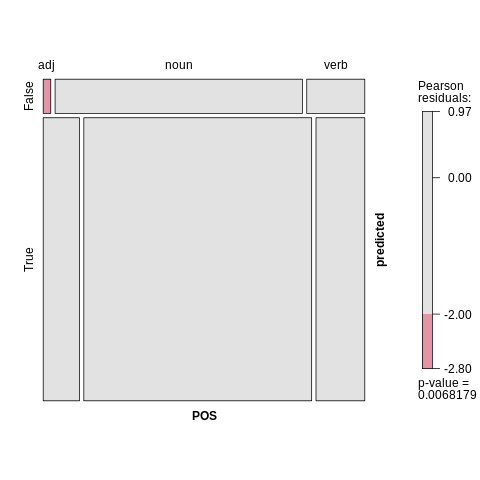

In [71]:
%%R
d = data_all_well_bad_pos[!(data_all_well_bad_pos$POS %in% c("o", "UNCLEAR")), ]
jpeg(file="pos_contingency.jpeg")
mosaic(~ predicted + POS,
       set_labels=list(POS=c("adj", "noun", "verb")),
       data = d,
       shade = TRUE,
       labeling_args = list(rot_labels = c(top = 0),tl_varnames = FALSE ),
       )
dev.off()

mosaic(~ predicted + POS,
       set_labels=list(POS=c("adj", "noun", "verb")),
       data = d,
       shade = TRUE,
       labeling_args = list(rot_labels = c(top = 0),tl_varnames = FALSE),
       )

##**DOMAIN**

In [72]:
%%R
total_dom = rbind(total_dom_coga, total_dom_eval)

In [73]:
%%R
t= printChiTest(total_dom, 4, 3, only=c( "EVENT", "OBJECT", "ABSTRACT", "CONCRETE"))

       
        ABSTRACT CONCRETE EVENT OBJECT
  False       61      118    49     20
  True       636      730   291    264

	Pearson's Chi-squared test

data:  t
X-squared = 18.493, df = 3, p-value = 0.000348

       
        ABSTRACT CONCRETE EVENT OBJECT
  False       61      118    49     20
  True       636      730   291    264
       
         ABSTRACT  CONCRETE     EVENT    OBJECT
  False  79.69387  96.95897  38.87506  32.47211
  True  617.30613 751.04103 301.12494 251.52789


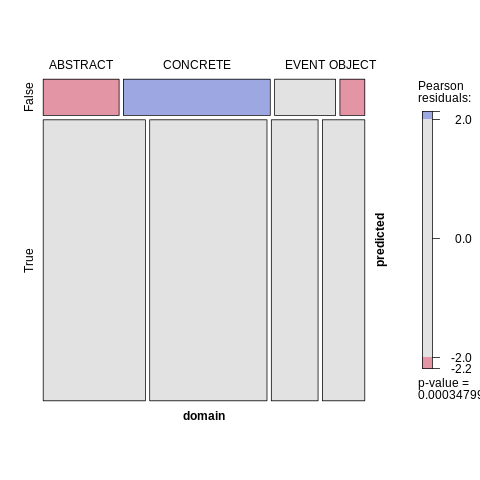

In [74]:
%%R
d = total_dom[(total_dom[,3] %in% c( "EVENT", "OBJECT", "ABSTRACT", "CONCRETE")),] #c("FOOD", "ANIMAL", "OBJECT", "SPACE", "PLANT", "PEOPLE", "EVENT", "ABSTRACT", "CONCRETE")
d = d %>% rename(predicted=V4, domain=V3)
jpeg(file="dom_contingency.jpeg")
mosaic(~predicted+domain,
       data = d,
       shade = TRUE,
       #labeling = left,
       labeling_args = list(rot_labels = c(top = 0), tl_varnames = FALSE),
       )
dev.off()
mosaic(~predicted+domain,
       data = d,
       shade = TRUE,
       #labeling = left,
       labeling_args = list(rot_labels = c(top = 0), tl_varnames = FALSE),
       )

##**Relations**

In [75]:
%%R
printChiTest(data_all_well_bad_coga, "results", "real_rel")

       
        ant hyper part_of syn
  False  12    29      16  23
  True  210   134     108  54

	Pearson's Chi-squared test

data:  t
X-squared = 32.416, df = 3, p-value = 4.276e-07

       
        ant hyper part_of syn
  False  12    29      16  23
  True  210   134     108  54
       
              ant     hyper   part_of      syn
  False  30.30717  22.25256  16.92833 10.51195
  True  191.69283 140.74744 107.07167 66.48805
       
        ant hyper part_of syn
  False  12    29      16  23
  True  210   134     108  54


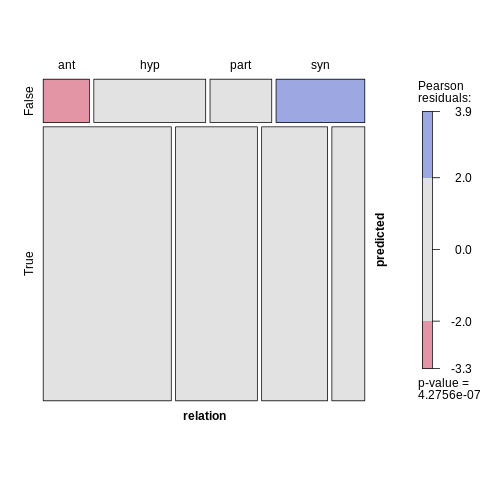

In [76]:
%%R
d = data_all_well_bad_coga
d = d %>% rename(predicted=results, relation=real_rel)
jpeg(file="rel_coga_contingency.jpeg")
mosaic(~ predicted + relation,
       #direction = c("v", "h"),
       set_labels=list(relation=c("ant", "hyp", "part", "syn")),
       data = d,
       shade = TRUE,
       labeling_args = list(rot_labels = c(top = 0),tl_varnames = FALSE),
    )
dev.off()
mosaic(~ predicted + relation,
       #direction = c("v", "h"),
       set_labels=list(relation=c("ant", "hyp", "part", "syn")),
       data = d,
       shade = TRUE,
       labeling_args = list(rot_labels = c(top = 0),tl_varnames = FALSE),
    )

## **Number of synsets**

In [77]:
%%R
preds = c(data_all_well_bad_coga$results, data_all_well_bad_eval$results)
nsor = c(data_all_well_bad_coga$nsynsests_source, data_all_well_bad_eval$nsynsests_source)
ntar = c(data_all_well_bad_coga$nsynsests_target, data_all_well_bad_eval$nsynsests_target)
data_all_well_bad_synsets = data.frame(results=preds, nsynsests_source=nsor, nsynsests_target=ntar)
print(length(preds))

[1] 1527


In [78]:
%%R
printTtestProductSynsest = function(data_all_well_bad) {
    #remove pairs with a word without synsets
    data_all_well_bad_syns = data_all_well_bad[data_all_well_bad$nsynsests_target != 0,]
    data_all_well_bad_syns = data_all_well_bad_syns[data_all_well_bad_syns$nsynsests_source != 0,]

    nsynsets_well = data_all_well_bad_syns[data_all_well_bad_syns$results == "True",]$nsynsests_target * data_all_well_bad_syns[data_all_well_bad_syns$results == "True",]$nsynsests_source
    nsynsets_bad = data_all_well_bad_syns[data_all_well_bad_syns$results == "False",]$nsynsests_target * data_all_well_bad_syns[data_all_well_bad_syns$results == "False",]$nsynsests_source

    datos = data.frame(
            grp = as.factor(c(rep("TRUE", length(nsynsets_well)), rep("FALSE", length(nsynsets_bad)))),
            val = c(nsynsets_well,nsynsets_bad) 
            )

    print(t.test(nsynsets_well, nsynsets_bad, var.equal = FALSE))
    print(fligner.test(x = list(nsynsets_well,nsynsets_bad)))
    print(wilcox.test(nsynsets_well, nsynsets_bad,))
    print(kruskal.test(data_all_well_bad_syns$nsynsests_target * data_all_well_bad_syns$nsynsests_source, data_all_well_bad_syns$results))
    boxplot(nsynsets_well, nsynsets_bad, names=c("well", "bad"))
}



	Welch Two Sample t-test

data:  nsynsets_well and nsynsets_bad
t = -0.83798, df = 217.46, p-value = 0.403
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -40.55070  16.35576
sample estimates:
mean of x mean of y 
 108.5394  120.6369 


	Fligner-Killeen test of homogeneity of variances

data:  list(nsynsets_well, nsynsets_bad)
Fligner-Killeen:med chi-squared = 5.3684, df = 1, p-value = 0.0205


	Wilcoxon rank sum test with continuity correction

data:  nsynsets_well and nsynsets_bad
W = 105741, p-value = 0.1799
alternative hypothesis: true location shift is not equal to 0


	Kruskal-Wallis rank sum test

data:  data_all_well_bad_syns$nsynsests_target * data_all_well_bad_syns$nsynsests_source and data_all_well_bad_syns$results
Kruskal-Wallis chi-squared = 1.7987, df = 1, p-value = 0.1799



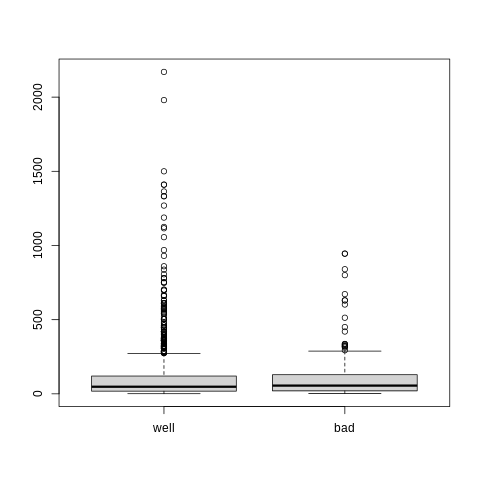

In [79]:
%%R
printTtestProductSynsest(data_all_well_bad_synsets)

##**Agreement**

In [80]:
%%R
mergeDataWithPairsMetada = function (data_all_well_bad, pairs_metadata) {
    # merge metadata with results
    data_pairs_all_well_bad = merge(data_all_well_bad, pairs_metadata, by.x=c("source", "target"), by.y = c("V1", "V3"))
    # cast to numeric agreement columns
    data_pairs_all_well_bad$V13 = as.numeric(data_pairs_all_well_bad$V13)
    data_pairs_all_well_bad$V15 = as.numeric(data_pairs_all_well_bad$V15)
    return (data_pairs_all_well_bad)
}

data_pairs_all_well_bad_coga = mergeDataWithPairsMetada(data_all_well_bad_coga, pairs_metadata_coga)
data_pairs_all_well_bad_eval = mergeDataWithPairsMetada(data_all_well_bad_eval, pairs_metadata_eval)


In [81]:
%%R
preds = c(data_pairs_all_well_bad_coga$results, data_pairs_all_well_bad_eval$results)
agr = c(data_pairs_all_well_bad_coga$V13, data_pairs_all_well_bad_eval$V13)
data_all_well_bad_agree = data.frame(results=preds, V13=agr)

In [82]:
%%R
printTtestAgreement = function(data_pairs_all_well_bad) {
    agr_well = data_pairs_all_well_bad[data_pairs_all_well_bad$results == "True",]$V13
    agr_bad = data_pairs_all_well_bad[data_pairs_all_well_bad$results == "False",]$V13
    print(length(agr_well)+length(agr_bad))
    print(t.test(agr_well, agr_bad, var.equal = FALSE, alternative = "greater"))
    print(fligner.test(x = list(agr_well,agr_bad)))
    print(wilcox.test(agr_well, agr_bad, alternative = "greater"))
    print(kruskal.test(data_pairs_all_well_bad$V13, data_pairs_all_well_bad$results))
    boxplot(agr_well, agr_bad, names=c("well", "bad"))
}

[1] 1565

	Welch Two Sample t-test

data:  agr_well and agr_bad
t = 3.2161, df = 244.61, p-value = 0.0007374
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 0.05778054        Inf
sample estimates:
mean of x mean of y 
 4.631333  4.512591 


	Fligner-Killeen test of homogeneity of variances

data:  list(agr_well, agr_bad)
Fligner-Killeen:med chi-squared = 5.6902, df = 1, p-value = 0.01706


	Wilcoxon rank sum test with continuity correction

data:  agr_well and agr_bad
W = 158307, p-value = 0.0001405
alternative hypothesis: true location shift is greater than 0


	Kruskal-Wallis rank sum test

data:  data_pairs_all_well_bad$V13 and data_pairs_all_well_bad$results
Kruskal-Wallis chi-squared = 13.194, df = 1, p-value = 0.0002808



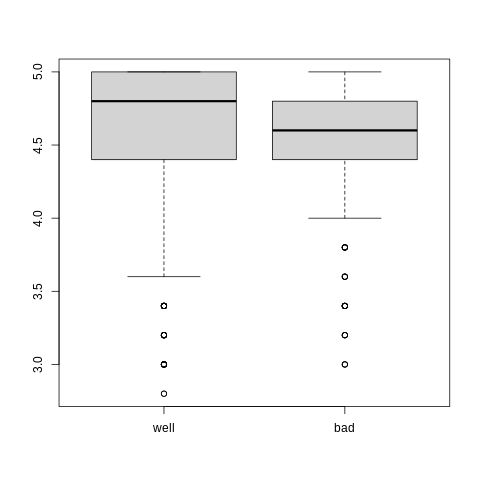

In [83]:
%%R
printTtestAgreement(data_all_well_bad_agree)

In [84]:
%%R
print(summary(data_all_well_bad_agree$V13))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.800   4.400   4.800   4.616   5.000   5.000 


In [85]:
%%R
print(sum(data_all_well_bad_agree$V13>=4)/length(data_all_well_bad_agree$V13))

[1] 0.9207668
